In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [4]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


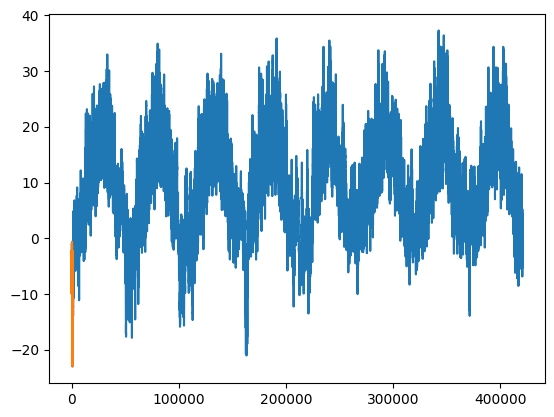

In [5]:
#Plotting the temperature timeseries

from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
#Plotting the first 10 days of the temperature timeseries

plt.plot(range(1440), temperature[:1440])
#Computing the number of samples we'll use for each data split

num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)
#Preparing the data
#Normalizing the data

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2)


In [6]:
for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))
#Instantiating datasets for training, validation, and testing

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [7]:
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)


In [8]:
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)
#Inspecting the output of one of our datasets

for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break
#A common-sense, non-machine-learning baseline
#Computing the common-sense baseline MAE


samples shape: (256, 120, 14)
targets shape: (256,)


In [9]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")
#Let's try a basic machine-learning model
#Training and evaluating a densely connected model

from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


Validation MAE: 2.44
Test MAE: 2.62


Epoch 1/10
819/819 [==============================] - 42s 45ms/step - loss: 12.6819 - mae: 2.7586 - val_loss: 10.5496 - val_mae: 2.5456
Epoch 2/10
819/819 [==============================] - 45s 54ms/step - loss: 9.0460 - mae: 2.3645 - val_loss: 10.9687 - val_mae: 2.5967
Epoch 3/10
819/819 [==============================] - 37s 44ms/step - loss: 8.3278 - mae: 2.2737 - val_loss: 9.9327 - val_mae: 2.4655
Epoch 4/10
819/819 [==============================] - 36s 43ms/step - loss: 7.9164 - mae: 2.2182 - val_loss: 11.5151 - val_mae: 2.6836
Epoch 5/10
819/819 [==============================] - 36s 43ms/step - loss: 7.5438 - mae: 2.1666 - val_loss: 11.3356 - val_mae: 2.6495
Epoch 6/10
819/819 [==============================] - 45s 54ms/step - loss: 7.2794 - mae: 2.1286 - val_loss: 11.1236 - val_mae: 2.6210
Epoch 7/10
819/819 [==============================] - 45s 55ms/step - loss: 7.1022 - mae: 2.1023 - val_loss: 11.0057 - val_mae: 2.6218
Epoch 8/10
819/819 [==============================] - 4

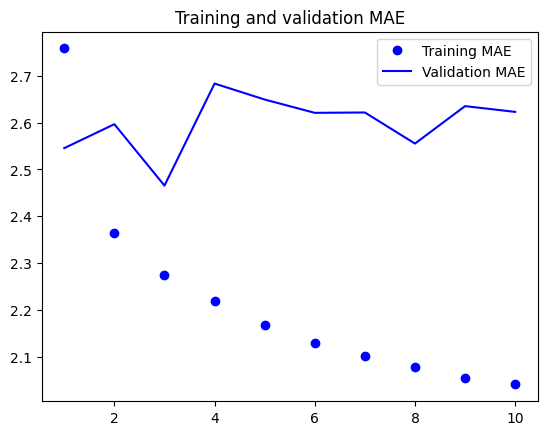

In [21]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.x",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
#Plotting results

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()


In [22]:
#Let's try a 1D convolutional model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
#A first recurrent baseline
#A simple LSTM-based model



Epoch 1/10
819/819 [==============================] - 44s 47ms/step - loss: 25.5503 - mae: 3.8901 - val_loss: 16.7556 - val_mae: 3.2061
Epoch 2/10
819/819 [==============================] - 47s 57ms/step - loss: 15.6316 - mae: 3.1464 - val_loss: 14.6312 - val_mae: 3.0231
Epoch 3/10
819/819 [==============================] - 47s 57ms/step - loss: 14.4119 - mae: 3.0170 - val_loss: 15.4460 - val_mae: 3.0568
Epoch 4/10
819/819 [==============================] - 46s 56ms/step - loss: 13.5907 - mae: 2.9295 - val_loss: 14.7180 - val_mae: 3.0250
Epoch 5/10
819/819 [==============================] - 47s 56ms/step - loss: 13.0013 - mae: 2.8626 - val_loss: 16.0589 - val_mae: 3.1335
Epoch 6/10
819/819 [==============================] - 46s 56ms/step - loss: 12.4816 - mae: 2.8019 - val_loss: 15.6807 - val_mae: 3.1524
Epoch 7/10
819/819 [==============================] - 46s 56ms/step - loss: 11.9862 - mae: 2.7462 - val_loss: 14.3125 - val_mae: 2.9955
Epoch 8/10
819/819 [============================

In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 46s 53ms/step - loss: 38.4776 - mae: 4.4817 - val_loss: 12.0231 - val_mae: 2.6628
Epoch 2/10
819/819 [==============================] - 42s 51ms/step - loss: 10.7663 - mae: 2.5549 - val_loss: 9.6746 - val_mae: 2.4277
Epoch 3/10
819/819 [==============================] - 39s 48ms/step - loss: 9.7750 - mae: 2.4401 - val_loss: 9.7320 - val_mae: 2.4316
Epoch 4/10
819/819 [==============================] - 42s 51ms/step - loss: 9.3950 - mae: 2.3901 - val_loss: 9.4856 - val_mae: 2.3948
Epoch 5/10
819/819 [==============================] - 42s 51ms/step - loss: 9.1774 - mae: 2.3597 - val_loss: 9.3429 - val_mae: 2.3838
Epoch 6/10
819/819 [==============================] - 48s 59ms/step - loss: 8.9676 - mae: 2.3327 - val_loss: 9.5073 - val_mae: 2.4058
Epoch 7/10
819/819 [==============================] - 39s 48ms/step - loss: 8.7199 - mae: 2.3012 - val_loss: 9.4993 - val_mae: 2.3971
Epoch 8/10
819/819 [==============================] - 39s 4

In [11]:
#Understanding recurrent neural networks
#NumPy implementation of a simple RNN

import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)
#A recurrent layer in Keras
#An RNN layer that can process sequences of any length

num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)
#An RNN layer that returns only its last output step

num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)
#An RNN layer that returns its full output sequence

num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)




(None, 16)
(None, 120, 16)


In [21]:
#Stacking RNN layers

inputs = keras.Input(shape=(steps, num_features))

x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)


#Advanced use of recurrent neural networks
#Using recurrent dropout to fight overfitting
#Training and evaluating a dropout-regularized LSTM

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)


model = keras.models.load_model("jena_lstm_dropout.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 226s 271ms/step - loss: 28.1520 - mae: 3.9121 - val_loss: 9.9103 - val_mae: 2.4558
Epoch 2/10
819/819 [==============================] - 222s 270ms/step - loss: 14.9235 - mae: 2.9963 - val_loss: 9.6143 - val_mae: 2.4181
Epoch 3/10
819/819 [==============================] - 212s 258ms/step - loss: 14.1405 - mae: 2.9153 - val_loss: 9.3680 - val_mae: 2.3822
Epoch 4/10
819/819 [==============================] - 221s 270ms/step - loss: 13.5309 - mae: 2.8518 - val_loss: 9.4704 - val_mae: 2.4024
Epoch 5/10
819/819 [==============================] - 222s 271ms/step - loss: 12.9737 - mae: 2.7967 - val_loss: 9.3286 - val_mae: 2.3797
Epoch 6/10
819/819 [==============================] - 206s 252ms/step - loss: 12.5460 - mae: 2.7484 - val_loss: 9.6331 - val_mae: 2.4191
Epoch 7/10
819/819 [==============================] - 220s 269ms/step - loss: 12.1261 - mae: 2.7030 - val_loss: 9.9823 - val_mae: 2.4754
Epoch 8/10
819/819 [=====================

In [20]:
inputs = keras.Input(shape=(steps, num_features))

x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(32, return_sequences=True)(inputs)
x = layers.SimpleRNN(64, return_sequences=True)(x)
outputs = layers.SimpleRNN(32)(x)


#Advanced use of recurrent neural networks
#Using recurrent dropout to fight overfitting
#Training and evaluating a dropout-regularized LSTM

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

model = keras.models.load_model("jena_lstm_dropout.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 242s 292ms/step - loss: 26.5987 - mae: 3.8138 - val_loss: 9.6742 - val_mae: 2.4236
Epoch 2/10
819/819 [==============================] - 210s 256ms/step - loss: 14.8023 - mae: 2.9855 - val_loss: 9.5182 - val_mae: 2.3899
Epoch 3/10
819/819 [==============================] - 218s 265ms/step - loss: 13.9631 - mae: 2.8994 - val_loss: 9.5322 - val_mae: 2.3878
Epoch 4/10
819/819 [==============================] - 220s 268ms/step - loss: 13.4451 - mae: 2.8396 - val_loss: 9.2781 - val_mae: 2.3634
Epoch 5/10
819/819 [==============================] - 227s 277ms/step - loss: 12.9626 - mae: 2.7940 - val_loss: 9.1165 - val_mae: 2.3322
Epoch 6/10
819/819 [==============================] - 222s 271ms/step - loss: 12.5805 - mae: 2.7480 - val_loss: 9.3165 - val_mae: 2.3609
Epoch 7/10
819/819 [==============================] - 221s 269ms/step - loss: 12.1743 - mae: 2.6994 - val_loss: 9.1958 - val_mae: 2.3563
Epoch 8/10
819/819 [=====================

In [19]:
inputs = keras.Input(shape=(steps, num_features))

x = layers.SimpleRNN(32, return_sequences=True)(inputs)
x = layers.SimpleRNN(64, return_sequences=True)(inputs)
x = layers.SimpleRNN(128, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)


#Advanced use of recurrent neural networks
#Using recurrent dropout to fight overfitting
#Training and evaluating a dropout-regularized LSTM

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

model = keras.models.load_model("jena_lstm_dropout.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 213s 257ms/step - loss: 28.4844 - mae: 3.9259 - val_loss: 9.8972 - val_mae: 2.4402
Epoch 2/10
819/819 [==============================] - 221s 270ms/step - loss: 14.6652 - mae: 2.9741 - val_loss: 9.3593 - val_mae: 2.3783
Epoch 3/10
819/819 [==============================] - 208s 254ms/step - loss: 13.7223 - mae: 2.8756 - val_loss: 9.2596 - val_mae: 2.3591
Epoch 4/10
819/819 [==============================] - 220s 268ms/step - loss: 13.1934 - mae: 2.8217 - val_loss: 9.0957 - val_mae: 2.3438
Epoch 5/10
819/819 [==============================] - 203s 248ms/step - loss: 12.7352 - mae: 2.7741 - val_loss: 9.6205 - val_mae: 2.4145
Epoch 6/10
819/819 [==============================] - 207s 253ms/step - loss: 12.3161 - mae: 2.7294 - val_loss: 9.0796 - val_mae: 2.3353
Epoch 7/10
819/819 [==============================] - 217s 265ms/step - loss: 12.0812 - mae: 2.7002 - val_loss: 9.1631 - val_mae: 2.3445
Epoch 8/10
819/819 [=====================

In [22]:
#Stacking recurrent layers
#Training and evaluating a dropout-regularized, stacked LSTM model

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_lstm_dropout.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_stacked_lstm_dropout.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 439s 529ms/step - loss: 26.3901 - mae: 3.7784 - val_loss: 9.6481 - val_mae: 2.4068
Epoch 2/10
819/819 [==============================] - 435s 531ms/step - loss: 13.7972 - mae: 2.8802 - val_loss: 9.1589 - val_mae: 2.3459
Epoch 3/10
819/819 [==============================] - 389s 475ms/step - loss: 12.5851 - mae: 2.7552 - val_loss: 9.7995 - val_mae: 2.4398
Epoch 4/10
819/819 [==============================] - 428s 523ms/step - loss: 11.6999 - mae: 2.6497 - val_loss: 10.0053 - val_mae: 2.4676
Epoch 5/10
819/819 [==============================] - 432s 528ms/step - loss: 10.8755 - mae: 2.5532 - val_loss: 10.4926 - val_mae: 2.5181
Epoch 6/10
819/819 [==============================] - 428s 523ms/step - loss: 10.2783 - mae: 2.4764 - val_loss: 10.7970 - val_mae: 2.5499
Epoch 7/10
819/819 [==============================] - 426s 520ms/step - loss: 9.7765 - mae: 2.4139 - val_loss: 11.4551 - val_mae: 2.6354
Epoch 8/10
819/819 [==================

In [28]:
#Using bidirectional RNNs
#Training and evaluating a bidirectional LSTM

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(32))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirectional_lstm.x",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_bidirectional_lstm.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 224s 268ms/step - loss: 15.9157 - mae: 2.9029 - val_loss: 9.8896 - val_mae: 2.4314
Epoch 2/10
819/819 [==============================] - 207s 253ms/step - loss: 7.8691 - mae: 2.1835 - val_loss: 10.4940 - val_mae: 2.5213
Epoch 3/10
819/819 [==============================] - 248s 302ms/step - loss: 6.7932 - mae: 2.0251 - val_loss: 10.6977 - val_mae: 2.5293
Epoch 4/10
819/819 [==============================] - 247s 301ms/step - loss: 5.9536 - mae: 1.8914 - val_loss: 11.5872 - val_mae: 2.6205
Epoch 5/10
819/819 [==============================] - 207s 253ms/step - loss: 5.3753 - mae: 1.7954 - val_loss: 11.4596 - val_mae: 2.6279
Epoch 6/10
819/819 [==============================] - 210s 256ms/step - loss: 4.9469 - mae: 1.7194 - val_loss: 11.6952 - val_mae: 2.6478
Epoch 7/10
819/819 [==============================] - 249s 304ms/step - loss: 4.5574 - mae: 1.6517 - val_loss: 12.1527 - val_mae: 2.7123
Epoch 8/10
819/819 [=====================